In [170]:
"""
import modules
"""
from prepare_data import prepare_df_from_mac_5_year as prepare_data
from prepare_data import prepare_data as prepare_IAMC
from emulate_reduction import emulator_v4 as emulate
from visualize_output import vis_emulator_v1 as v1_plot
from pym import pym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

dir(prepare_IAMC)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'combine_azure_ctax',
 'np',
 'os',
 'pd',
 'prepare_data',
 'pym']

In [2]:
"""
load data
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
PATH_IAMC_MYM = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_mym/'
PATH_IAMC_COSTS = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_costs/'
PATH_IAMC_CSV = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_csv/'

FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

# new paths, from IAMC databese
IAMC_database = pd.read_excel(PATH_IAMC + FILENAME_IAMC, sheet_name='data')

C:\Users\toonv\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\toonv\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\toonv\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\toonv\Anaconda3\lib\site-packages\pan

,2020,2030,2040,2050,2060,2070,2080,2090,2100
1261,0.0,2519.842100,3174.802104,3634.241186,4000.000000,4000.000000,4000.000000,4000.000000,4000.0
1262,0.0,2339.214191,2947.225199,3373.730661,3713.271067,4000.000000,4000.000000,4000.000000,4000.0
1263,0.0,2201.284833,2773.445097,3174.802104,3494.321859,3764.144116,4000.000000,4000.000000,4000.0
1264,0.0,2091.031834,2634.535024,3015.789765,3319.306133,3575.614140,3799.657006,4000.000000,4000.0
1265,0.0,2000.000000,2519.842100,2884.499141,3174.802104,3419.951893,3634.241186,3825.862366,4000.0


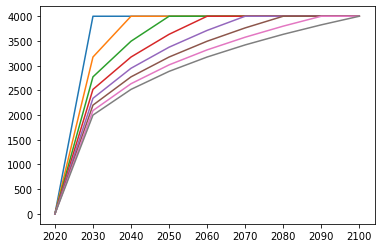

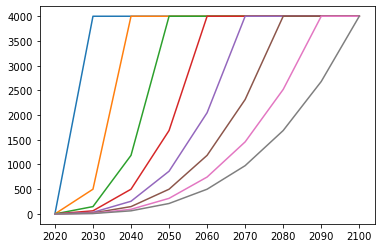

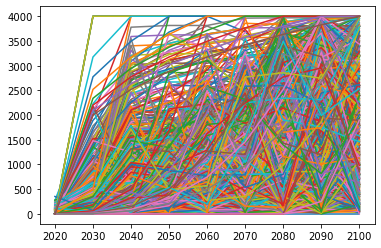

In [108]:
"""
prepare data from IAMC database
"""

reload(IAMC)

YEAR_STEP = 10
MAX_CTAX = 4000
MODELS = ['IMAGE']
STEP_CTAX = 200
MAX_RAND = 2

raw_data = prepare_data.prepare_data(IAMC_database)

carbon_prices, models_ctax = raw_data.filter_iamc(YEAR_STEP, 'Price|Carbon', MAX_CTAX, MODELS)
# mean_temp, models_temp = raw_data.filter_iamc(year_step, 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED',
#                                               MAX_CTAX, MODELS)

# scaled and lin ctax
scaled_ctax_paths = raw_data.scale_ctax(STEP_CTAX)
lin_ctax_paths = raw_data.get_linear(MAX_CTAX)
sparse_ctax_paths = raw_data.sparse_linear(MAX_CTAX)
random_ctax_paths = raw_data.get_random(MAX_RAND, MAX_CTAX)
cubic_ctax_paths = raw_data.get_cubic(MAX_CTAX)
cubicroot_ctax_paths = raw_data.get_cubicroot(MAX_CTAX)
sparse_cubicroot_paths = raw_data.sparse_cubicroot(MAX_CTAX)
sparse_cubic_paths = raw_data.sparse_cubic(MAX_CTAX)

# plot paths
raw_data.plot_ctax_paths(sparse_cubicroot_paths)
raw_data.plot_ctax_paths(sparse_cubic_paths)

# merged dataframe
all_paths = raw_data.merge_all(PATH_IAMC, 'all_ctax_paths.xlsx')
raw_data.plot_ctax_paths(all_paths)

# save data to path
raw_data.prepare_mym(all_paths, PATH_IAMC_MYM, PATH_IAMC_CSV, 'ctax_train_')

all_paths.tail()

In [190]:
"""
load reductions calculated using the costcurvecooker

input: csv of all reductions (prepared using organize_azure_output.py)
        and definded ctax paths 
        
output: pandas dataframe with ctax paths and reductions until given year
"""

reload(prepare_IAMC)

# load reduction from azure output
reductions = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax_total.csv')
years = [1971, 1981, 1991, 2001, 2011, 2021, 2031, 2041, 2051, 2061, 2071, 2081, 2091, 2100]
columns = ['ctax_index', 'region'] + years  # dont know how to set headers for multi-index
reductions.columns = columns

# load ctax paths csv
ctax_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/IAMC_paths/all_ctax_paths.xlsx', index_col=[0])
ctax_paths.index.name = 'ctax_index'

# functie met jaar en regio geeft dataframe met paths en reducties (%)
data_for_emulator = prepare_IAMC.combine_azure_ctax(2060, 11, ctax_paths, reductions)
data_for_emulator.year = 2060
data_for_emulator.region = 11
data_for_emulator.tail()

2060


,2020,2030,2040,2050,2060,reduction
1261,0.0,2519.842100,3174.802104,3634.241186,4000.000000,90.672087
1262,0.0,2339.214191,2947.225199,3373.730661,3713.271067,91.846032
1263,0.0,2201.284833,2773.445097,3174.802104,3494.321859,90.227172
1264,0.0,2091.031834,2634.535024,3015.789765,3319.306133,91.397606
1265,0.0,2000.000000,2519.842100,2884.499141,3174.802104,90.068699


In [63]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2060
region = 11
TIMERSTEP = 10
test_size = 0.1
stepsize_ctax_paths = 10
number_of_weights = 2

In [163]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_data)

lin_reduction = prepare_data.reduction_df(df_linear, year, region)
cubic_reduction = prepare_data.reduction_df(df_cubic, year, region)
root_reduction = prepare_data.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_data.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_data.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_data.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

print(combi.year)

combi.tail()

2060


,2020,2030,2040,2050,2060,reduction
196,0.0,2469.445258,3111.306062,3561.556362,3920.0,95.4218
197,0.0,2482.044468,3127.180072,3579.727568,3940.0,95.4228
198,0.0,2494.643679,3143.054083,3597.898774,3960.0,95.4238
199,0.0,2507.242889,3158.928093,3616.069980,3980.0,95.4248
200,0.0,2519.842100,3174.802104,3634.241186,4000.0,95.4258


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v3.py:71: RuntimeWarning: invalid value encountered in true_divide
  stepsize_ctax = index * 20
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v3.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  #            print(len(delta_c_slice), len(lin_reduction_step), len(train_reduction_step))
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v3.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:

C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v3.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  #            print(len(delta_c_slice), len(lin_reduction_step), len(train_reduction_step))
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v3.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v3.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

weights dataframe: 
             0          1  ctax
0    0.000000   0.000000     0
1  -14.283412  -7.691068   200
2  -23.897228 -12.867738   400
3  -36.936983 -19.889145   600
4  -42.088514 -22.663046   800
5  -33.059660 -17.801355  1000
6  -16.849399  -9.072754  1200
7  -10.657742  -5.738784  1400
8   -3.008685  -1.620061  1600
9    8.569854   4.614537  1800
10  10.539684   5.675215  2000
11   8.891459   4.787709  2200
12   8.305497   4.472191  2400
13   6.089375   3.278894  2600
14   1.587415   0.854762  2800
15  -0.663565  -0.357304  3000
16  -2.569277  -1.383457  3200
17  -2.767990  -1.490456  3400
18  -0.278606  -0.150018  3600
19  -0.278606  -0.150018  3800
20  -0.278606  -0.150018  4000


,test reduction,final ctax,real reduction
0,17.3402,60.0,17.3402
1,74.9998,540.0,60.4825
2,82.7428,740.0,66.2008
3,84.0782,780.0,67.5362
4,91.2702,1060.0,78.2768
5,91.9392,1080.0,78.9458
6,87.5650,1200.0,80.9427
7,87.1994,1380.0,83.0106
8,90.3462,1680.0,89.1637
9,88.0587,2000.0,92.2011


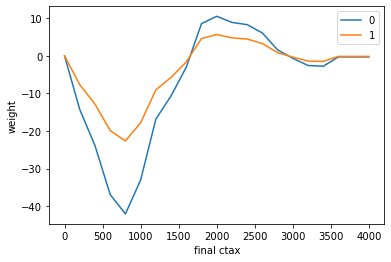

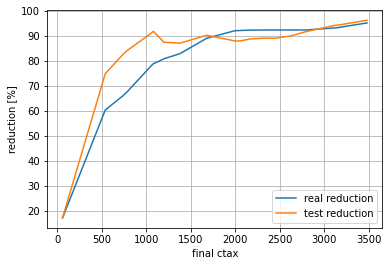

In [66]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, cubic_paths, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
x.test_ctax_paths() 


method:  multivariate linear regression 
 RMSE:  20.544663524181804 
 R-squared:  0.5435000302450663
method:  polynomial regression 
 RMSE:  11.08011469842746 
 R-squared:  0.8672204478245619
method:  regression tree 
 RMSE:  4.276374049067202 
 R-squared:  0.9802214678261302
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   20.2s finished


{'max_features': 'sqrt', 'n_estimators': 300}
method:  regression forest 
 RMSE:  3.4909975203123946 
 R-squared:  0.986819200069141
{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
method:  SVM 
 RMSE:  2.8879469771900275 
 R-squared:  0.9909796971697205


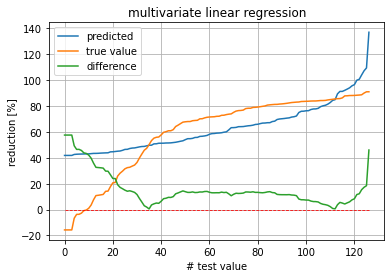

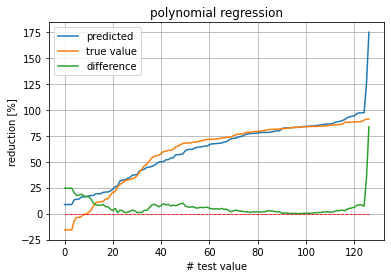

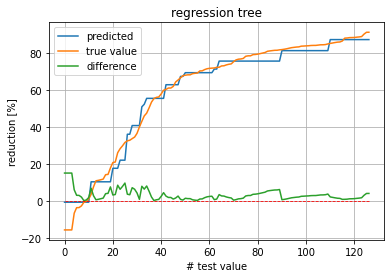

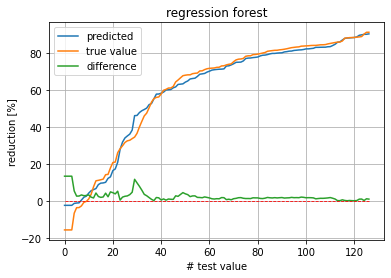

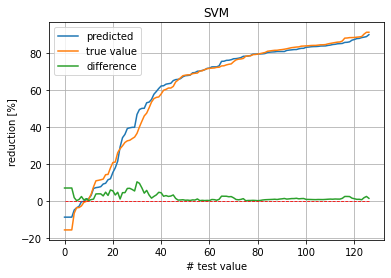

In [207]:
reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, data_for_emulator, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
multi_lin_plot = x.test_regr(multi_lin_regr_mod)

# polynomial regression model
degree = 3
poly_regr_mod = x.train_ctax_PR(degree)
poly_regr_plot = x.test_regr(poly_regr_mod)

# # Ridge regression
# alpha = 1
# ridge_mod = x.train_ctax_ridge(alpha)
# ridge_plot = x.test_regr(ridge_mod)

# # lasso regression
# alpha = 1
# lasso_mod = x.train_ctax_lasso(alpha)
# lasso_plot = x.test_regr(lasso_mod)

# Regression tree
max_depth = 5
regr_tree = x.train_ctax_tree(max_depth)
tree_plot = x.test_regr(regr_tree)

# Random forest
regr_forest = x.train_ctax_forest(max_depth)
forest_plot = x.test_regr(regr_forest)

# SVM
svm_regr = x.train_SVM()
svm_plot = x.test_regr(svm_regr)

# MLPRegressor
# MLP_regr = x.train_MLPRegressor()
# MLP_plot = x.test_regr(MLP_regr)
